#### Exploring Grad-CAM Functions
Blog post [link](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353)

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks, Model

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *
from gradcam import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [5]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# specify variables
path = 'processed_data/WM-clean-paper'
result_path = 'results'

filename = 'WM-clean-paper'
map_column = 'waferMap224'

model_id = 'yutandem'
data_id = 'paper'
note = '' # -optional

detect_model = 'yudetect-paper'
classify_model = 'yuclassify-paper'

In [7]:
# load test set(s) to be used
# directly from S3 (using boto3 resource)
start = time.time()

test_key = f'{path}/{filename}-test.pkl'
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Test: {len(test)}")

Wall time: 21.37 seconds
Test: 25943


In [8]:
# load saved classify model from S3
start = time.time()

classify = s3_get_keras_model(classify_model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

#### Test out Grad-CAM functions
Grad cam functions used:
- `GradCam`: produces Grad-CAM heatmap
- `generate_img_bgr`: produces a greyscale image that is ready for superimposing with the Grad-CAM heatmap
- `superimpose`: produces a superimposed image of the Grad-CAM heatmap over the grayscale image of the wafer

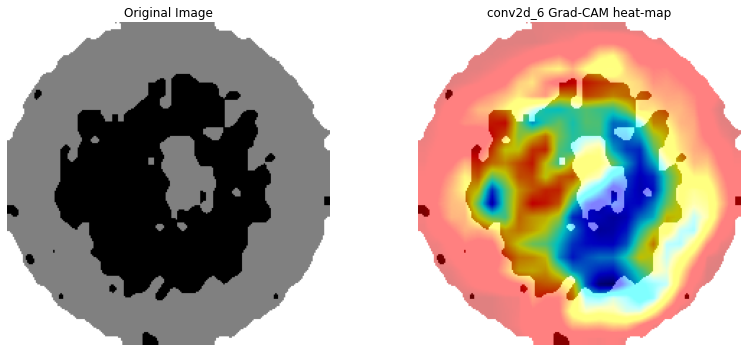

In [16]:
img = test.waferMap224[1001]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d_6'
grad_cam=GradCam(classify, img, layer_name)

# generate superimposed image
img_bgr = generate_img_bgr(img)
grad_cam_superimposed = superimpose(img_bgr, grad_cam, emphasize=False, img_wt=1, heatmap_wt=0.75)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

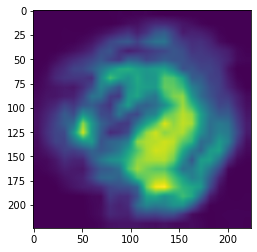

In [17]:
plt.imshow(grad_cam)